In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os

import yaml
import torch
import torch.multiprocessing as mp

import utils
import trainers

from run_trainer import make_cfg


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
args = AttrDict(
            {
                "cfg": "cfgs/imgrec_celeba.yaml",
                "load_root": "data",
                "save_root": "save",
                "name": None,
                "tag": None,
                "cudnn": True,
                "wandb_upload": False,
                "port_offset": 0
            }
        )

In [4]:
cfg = make_cfg(args)

cfg
trainer = trainers.trainers_dict[cfg['trainer']](0, cfg)

[01-14 21:15:08] Environment setup done.


In [5]:
cfg["train_dataset"]["loader"]["batch_size"] = 4

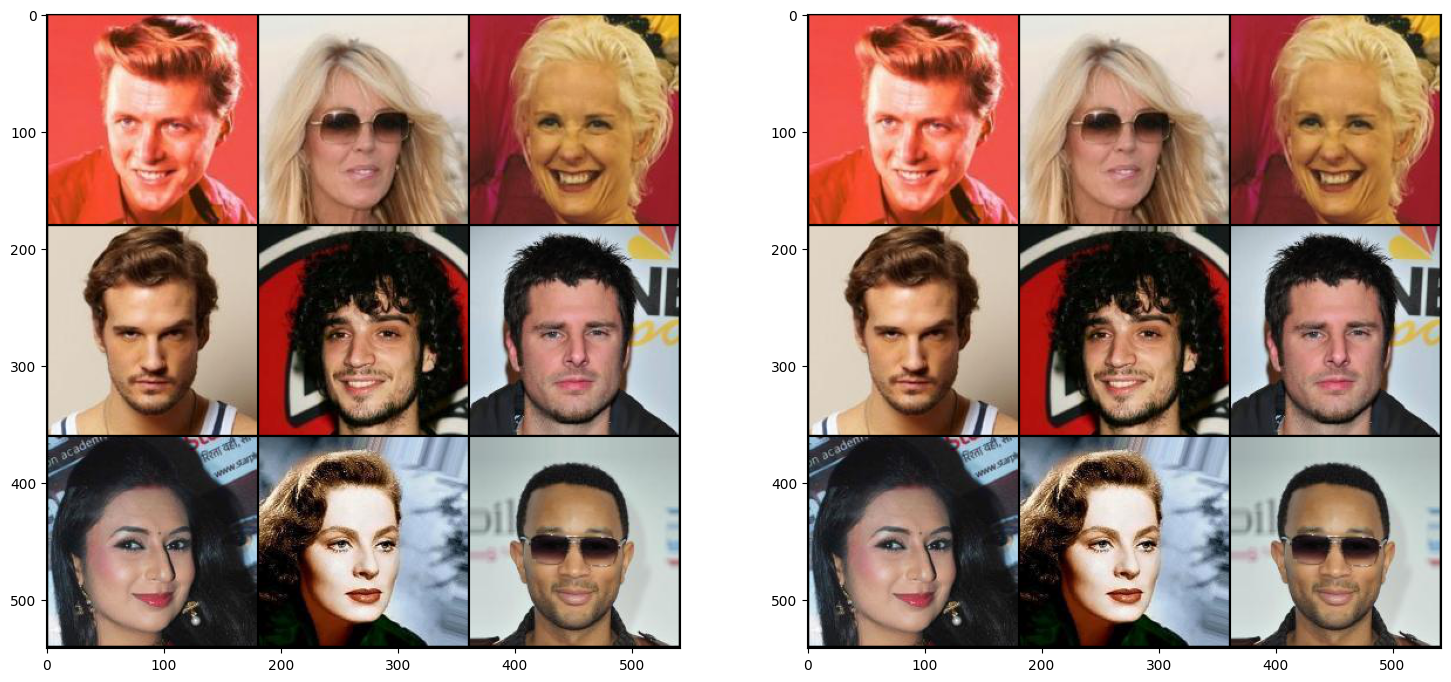

In [6]:
import numpy as np
import torchvision
import datasets
import matplotlib.pyplot as plt

train_dataset = datasets.make(cfg['train_dataset'])

sample_indices = np.random.choice(len(train_dataset), size=9, replace=False)
sample_inp = []
sample_gt = []
for i in sample_indices:
    inp, gt = train_dataset[i]["inp"], train_dataset[i]["gt"]
    sample_inp.append(inp)
    sample_gt.append(gt)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_inp, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_gt, nrow=3).permute(1, 2, 0).float().cpu().numpy())

In [7]:
trainer.make_datasets()

[01-14 21:15:10] Train dataset: len=162770
[01-14 21:15:10] Test dataset: len=19962


In [8]:
trainer.make_model()
model = trainer.model
model_ddp = trainer.model_ddp

[01-14 21:15:11] Model: #params=44.5M


In [9]:
max_epoch = cfg['max_epoch']
eval_epoch = cfg.get('eval_epoch', max_epoch + 1)
vis_epoch = cfg.get('vis_epoch', max_epoch + 1)
save_epoch = cfg.get('save_epoch', max_epoch + 1)
epoch_timer = utils.EpochTimer(max_epoch)

max_epoch, eval_epoch, vis_epoch, save_epoch, epoch_timer

(30, 1, 5, 31, <utils.common.EpochTimer at 0x7ff48023b940>)

In [10]:
import utils

trainer.optimizer = utils.make_optimizer(trainer.model_ddp.parameters(), cfg['optimizer'])

for data in trainer.train_loader:
    break
    
data = {k: v.cuda() for k, v in data.items()}

In [11]:
gt = data.pop('gt')
B = gt.shape[0]
print(B)
hyponet = model_ddp(data)
hyponet

4


HypoMlp(
  (relu): ReLU()
)

In [12]:
# tokenizer

import torch.nn.functional as F
x = data['inp']
p = model_ddp.tokenizer.patch_size
print(x.shape, p)
x = F.unfold(x, p, stride=p, padding=model_ddp.tokenizer.padding) # (B, C * p * p, L)
print(x.shape)
x = x.permute(0, 2, 1).contiguous()
print(x.shape)
print(model_ddp.tokenizer.prefc)
x = model_ddp.tokenizer.prefc(x) + model_ddp.tokenizer.posemb.unsqueeze(0)
print(x.shape)

print("################")
#print(model_ddp.tokenizer)

dtokens = model_ddp.tokenizer(data)
print(dtokens.shape)

torch.Size([4, 3, 178, 178]) (9, 9)
torch.Size([4, 243, 400])
torch.Size([4, 400, 243])
Linear(in_features=243, out_features=768, bias=True)
torch.Size([4, 400, 768])
################
torch.Size([4, 400, 768])


In [37]:
# debug how hyponet was formed

In [36]:
hyponet = model_ddp.hyponet
hyponet.param_shapes.items()

dict_items([('wb0', (257, 256)), ('wb1', (257, 256)), ('wb2', (257, 256)), ('wb3', (257, 256)), ('wb4', (257, 3))])

In [82]:
import torch.nn as nn

n_groups = 64
dim = 768

model_ddp.base_params = nn.ParameterDict()
n_wtokens = 0
wtoken_postfc = nn.ModuleDict()
wtoken_rng = dict()

print(model_ddp.hyponet.param_shapes.items())

from models.trans_inr import init_wb

for name, shape in model_ddp.hyponet.param_shapes.items():
    model_ddp.base_params[name] = nn.Parameter(init_wb(shape))
    g = min(n_groups, shape[1])
    print(name, shape, g)
    assert shape[1] % g == 0
    model_ddp.wtoken_postfc[name] = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, shape[0] - 1),
            )
    model_ddp.wtoken_rng[name] = (n_wtokens, n_wtokens + g)
    n_wtokens += g

model_ddp.wtokens = nn.Parameter(torch.randn(n_wtokens, dim))

print(model_ddp.base_params)
print(model_ddp.wtoken_postfc)
print(model_ddp.wtoken_rng)
print(model_ddp.wtokens.shape)

dict_items([('wb0', (257, 256)), ('wb1', (257, 256)), ('wb2', (257, 256)), ('wb3', (257, 256)), ('wb4', (257, 3))])
wb0 (257, 256) 64
wb1 (257, 256) 64
wb2 (257, 256) 64
wb3 (257, 256) 64
wb4 (257, 3) 3
ParameterDict(
    (wb0): Parameter containing: [torch.FloatTensor of size 257x256]
    (wb1): Parameter containing: [torch.FloatTensor of size 257x256]
    (wb2): Parameter containing: [torch.FloatTensor of size 257x256]
    (wb3): Parameter containing: [torch.FloatTensor of size 257x256]
    (wb4): Parameter containing: [torch.FloatTensor of size 257x3]
)
ModuleDict(
  (wb0): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (wb1): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (wb2): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_feat

In [77]:
import einops

B = dtokens.shape[0]
wtokens = einops.repeat(model_ddp.wtokens, 'n d -> b n d', b=B)
model_ddp.wtokens.shape, wtokens.shape

(torch.Size([259, 768]), torch.Size([4, 259, 768]))

In [80]:
trans_inp = torch.cat([dtokens, wtokens.cuda()], dim=1)
trans_out = model_ddp.transformer_encoder(trans_inp)
trans_out = trans_out[:, -len(model_ddp.wtokens):, :]

In [81]:
trans_inp.shape, trans_out.shape

(torch.Size([4, 659, 768]), torch.Size([4, 259, 768]))

In [76]:
params = dict()

In [73]:
trans_out = trans_out[:, -len(model_ddp.wtokens):, :]
trans_out.shape

torch.Size([4, 259, 768])

In [87]:
model_ddp.cuda()
hyponet = model_ddp(data)

In [89]:
hyponet

HypoMlp(
  (relu): ReLU()
)

In [96]:
from utils.geometry import make_coord_grid
import einops

In [106]:
coord = make_coord_grid(gt.shape[-2:], (-1, 1), device=gt.device)
# print(coord.shape)
coord = einops.repeat(coord, 'h w d -> b h w d', b=B)
# print(coord.shape)

from models.hyponets.layers import batched_linear_mm

with torch.no_grad():
    # pred = hyponet(coord)
    x = coord
    B, query_shape = x.shape[0], x.shape[1: -1]
    print(x.shape)
    x = x.view(B, -1, x.shape[-1])
    print(x.shape)
    x = hyponet.convert_posenc(x)
    print(x.shape)
    

    for i in range(hyponet.depth):
        x = batched_linear_mm(x, hyponet.params[f'wb{i}'])
        print("............ {}".format(x.shape))
        if i < hyponet.depth - 1:
            x = hyponet.relu(x)
        else:
            x = x + hyponet.out_bias
            
    x = x.view(B, *query_shape, -1)
    print(x.shape)

torch.Size([4, 178, 178, 2])
torch.Size([4, 31684, 2])
torch.Size([4, 31684, 256])
............ torch.Size([4, 31684, 256])
............ torch.Size([4, 31684, 256])
............ torch.Size([4, 31684, 256])
............ torch.Size([4, 31684, 256])
............ torch.Size([4, 31684, 3])
torch.Size([4, 178, 178, 3])


In [46]:
args = AttrDict(
            {
                "cfg": "cfgs/nvs_shapenet_cars_2shot.yaml",
                "load_root": "data",
                "save_root": "save",
                "name": None,
                "tag": None,
                "cudnn": True,
                "wandb_upload": False,
                "port_offset": 0
            }
        )

cfg = make_cfg(args)
trainer = trainers.trainers_dict[cfg['trainer']](0, cfg)

[01-14 18:06:32] Environment setup done.
[01-14 18:06:32] Environment setup done.
[01-14 18:06:32] Environment setup done.
[01-14 18:06:32] Environment setup done.
[01-14 18:06:32] Environment setup done.
[01-14 18:06:32] Environment setup done.


Missing obj at data/learnit_shapenet/cars/302612708e86efea62d2c237bfbc22ca, skipped.
Missing obj at data/learnit_shapenet/cars/4ddef66f32e1902d3448fdcb67fe08ff, skipped.
Missing obj at data/learnit_shapenet/cars/e6c22be1a39c9b62fb403c87929e1167, skipped.
Missing obj at data/learnit_shapenet/cars/8070747805908ae62a9eb0f146e94477, skipped.
Missing obj at data/learnit_shapenet/cars/5bf2d7c2167755a72a9eb0f146e94477, skipped.
Missing obj at data/learnit_shapenet/cars/3c33f9f8edc558ce77aa0b62eed1492, skipped.
Missing obj at data/learnit_shapenet/cars/7aa9619e89baaec6d9b8dfa78596b717, skipped.
Missing obj at data/learnit_shapenet/cars/93ce8e230939dfc230714334794526d4, skipped.
Missing obj at data/learnit_shapenet/cars/d6ee8e0a0b392f98eb96598da750ef34, skipped.
Missing obj at data/learnit_shapenet/cars/986ed07c18a2e5592a9eb0f146e94477, skipped.
Missing obj at data/learnit_shapenet/cars/5973afc979049405f63ee8a34069b7c5, skipped.
Missing obj at data/learnit_shapenet/cars/407f2811c0fe4e9361c6c614

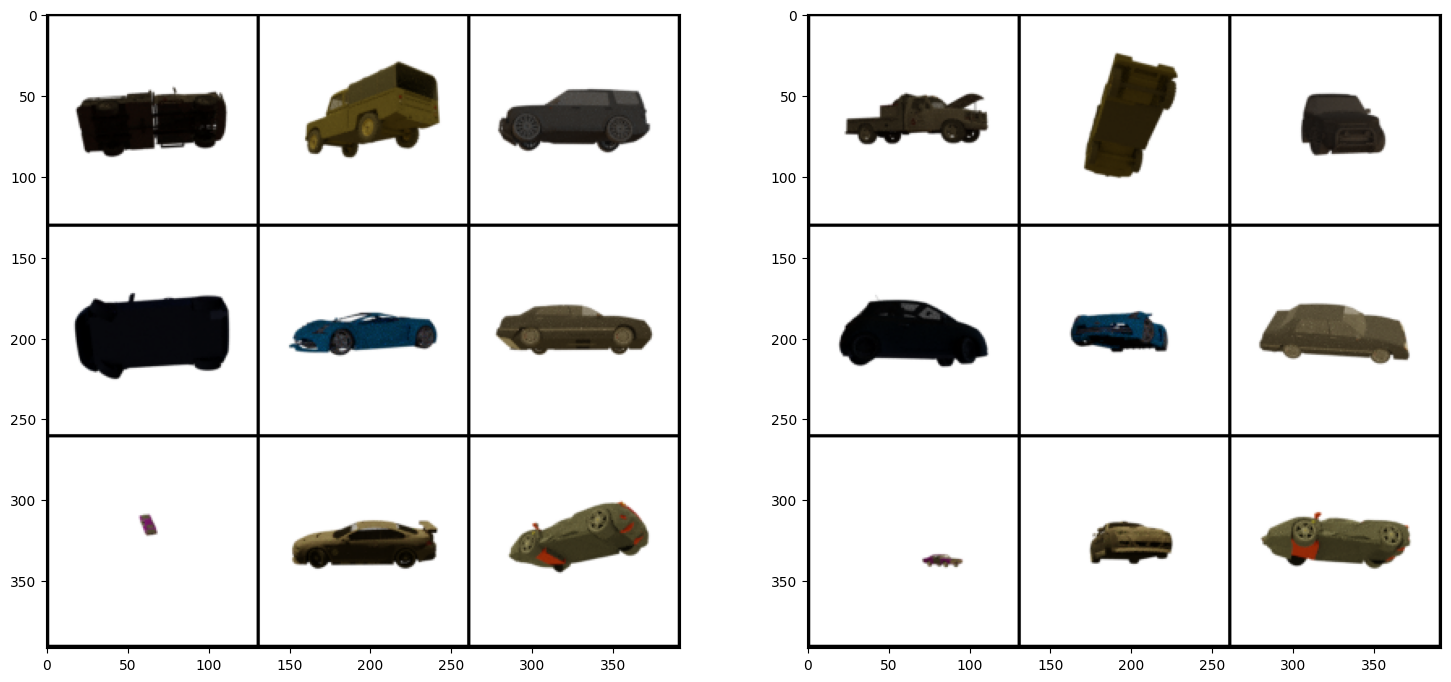

In [63]:
import numpy as np
import torchvision
import datasets
import matplotlib.pyplot as plt

train_dataset = datasets.make(cfg['train_dataset'])

sample_indices = np.random.choice(len(train_dataset), size=9, replace=False)
sample_inp = []
sample_gt = []
for i in sample_indices:
    inp, gt = train_dataset[i]["support_imgs"][0], train_dataset[i]["query_imgs"][0]
    sample_inp.append(inp)
    sample_gt.append(gt)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_inp, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_gt, nrow=3).permute(1, 2, 0).float().cpu().numpy())

In [56]:
train_dataset[0].keys()

dict_keys(['support_imgs', 'support_poses', 'support_focals', 'query_imgs', 'query_poses', 'query_focals', 'near', 'far'])

In [59]:
train_dataset[0]["support_poses"][0]

tensor([[-9.9965e-01,  3.7906e-04, -2.6513e-02, -1.0688e-01],
        [-2.6515e-02, -1.4291e-02,  9.9955e-01,  4.0293e+00],
        [ 0.0000e+00,  9.9990e-01,  1.4296e-02,  5.7629e-02]])

In [60]:
train_dataset[0]["support_focals"][0]

tensor([177.7778, 177.7778])

In [62]:
train_dataset[0]["query_imgs"].shape

torch.Size([1, 3, 128, 128])

In [64]:
train_dataset[0]["query_focals"][0]

tensor([177.7778, 177.7778])